In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Rescaling,Conv2D,MaxPooling2D,Flatten,Dense,Dropout

In [ ]:
batch_size = 10
img_height = 180
img_width = 180

In [ ]:
import pathlib
train_dir = pathlib.Path('train_2')
val_dir = pathlib.Path('val_2')
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  val_dir,
  
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names


Found 196 files belonging to 6 classes.
Found 196 files belonging to 6 classes.


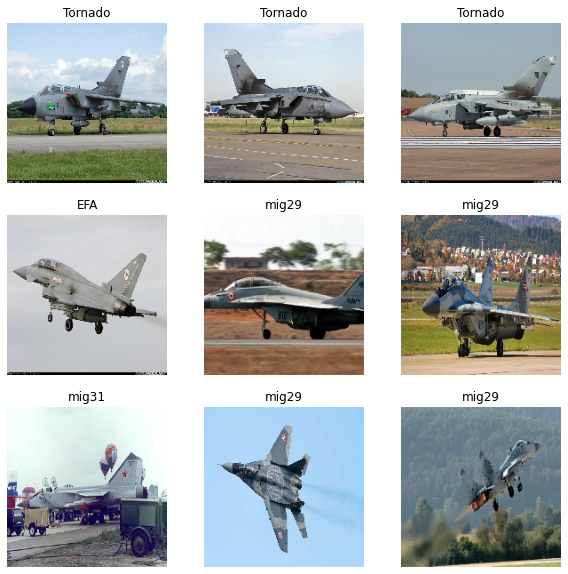

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(10, 180, 180, 3)
(10,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(10).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
normalization_layer = layers.Rescaling(1./255)

In [ ]:
import os
import cv2
import imghdr

def check_images( s_dir, ext_list):
    bad_images=[]
    bad_ext=[]
    s_list= os.listdir(s_dir)
    for klass in s_list:
        klass_path=os.path.join (s_dir, klass)
        print ('processing class directory ', klass)
        if os.path.isdir(klass_path):
            file_list=os.listdir(klass_path)
            for f in file_list:               
                f_path=os.path.join (klass_path,f)
                tip = imghdr.what(f_path)
                if ext_list.count(tip) == 0:
                  bad_images.append(f_path)
                if os.path.isfile(f_path):
                    try:
                        img=cv2.imread(f_path)
                        shape=img.shape
                    except:
                        print('file ', f_path, ' is not a valid image file')
                        bad_images.append(f_path)
                else:
                    print('*** fatal error, you a sub directory ', f, ' in class directory ', klass)
        else:
            print ('*** WARNING*** you have files in ', s_dir, ' it should only contain sub directories')
    return bad_images, bad_ext

source_dir ='val_2'
good_exts=['jpg', 'png', 'jpeg', 'gif', 'bmp' ] # list of acceptable extensions
bad_file_list, bad_ext_list=check_images(source_dir, good_exts)
if len(bad_file_list) !=0:
    print('improper image files are listed below')
    for i in range (len(bad_file_list)):
        print (bad_file_list[i])
else:
    print(' no improper image files were found')

processing class directory  F16
processing class directory  Tornado
processing class directory  F18
processing class directory  mig31
processing class directory  EFA
processing class directory  mig29
improper image files are listed below
val_2/mig31/mig31_91.jpg
val_2/mig29/mig29_30.jpg
val_2/mig29/mig29_125.jpg


In [ ]:
!rm -r  test_2/.ipynb_checkpoints

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [ ]:
data_augmentation = Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [ ]:
num_classes = len(class_names)
model = Sequential([
  data_augmentation,
  Rescaling(1./255),
  Conv2D(32, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(64, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(64, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(64, 3, padding='same', activation='relu'),
  Dropout(0.3),
  Flatten(),
  Dense(128, activation='relu'),
  Dense(num_classes)
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
class_names

['EFA', 'F16', 'F18', 'Tornado', 'mig29', 'mig31']

In [ ]:
epochs=100
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

history = model.fit(
  val_ds,
  validation_data=val_ds,
  epochs=epochs
  
)

Epoch 1/100
20/20 [==============================] - 2s 56ms/step - loss: 1.9022 - accuracy: 0.1224 - val_loss: 1.7982 - val_accuracy: 0.1888
Epoch 2/100
20/20 [==============================] - 1s 45ms/step - loss: 1.8150 - accuracy: 0.1531 - val_loss: 1.7906 - val_accuracy: 0.2500
Epoch 3/100
20/20 [==============================] - 1s 44ms/step - loss: 1.7897 - accuracy: 0.1684 - val_loss: 1.7736 - val_accuracy: 0.1837
Epoch 4/100
20/20 [==============================] - 1s 44ms/step - loss: 1.7721 - accuracy: 0.1888 - val_loss: 1.7229 - val_accuracy: 0.2143
Epoch 5/100
20/20 [==============================] - 1s 45ms/step - loss: 1.7464 - accuracy: 0.2143 - val_loss: 1.6576 - val_accuracy: 0.2857
Epoch 6/100
20/20 [==============================] - 1s 45ms/step - loss: 1.5999 - accuracy: 0.3214 - val_loss: 1.4031 - val_accuracy: 0.3724
Epoch 7/100
20/20 [==============================] - 1s 44ms/step - loss: 1.4704 - accuracy: 0.3418 - val_loss: 1.3474 - val_accuracy: 0.3980
Epoch 

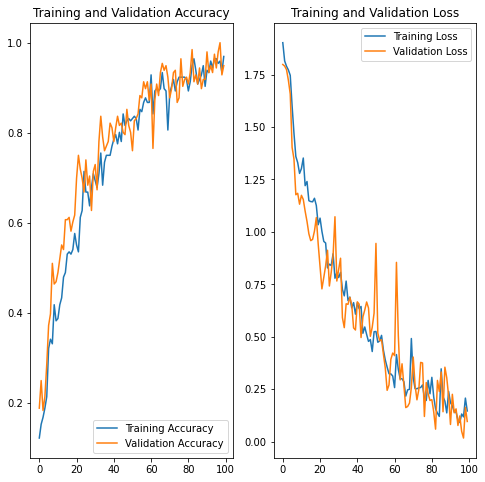

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

This image most likely belongs to F16 with a 99.89 percent confidence.


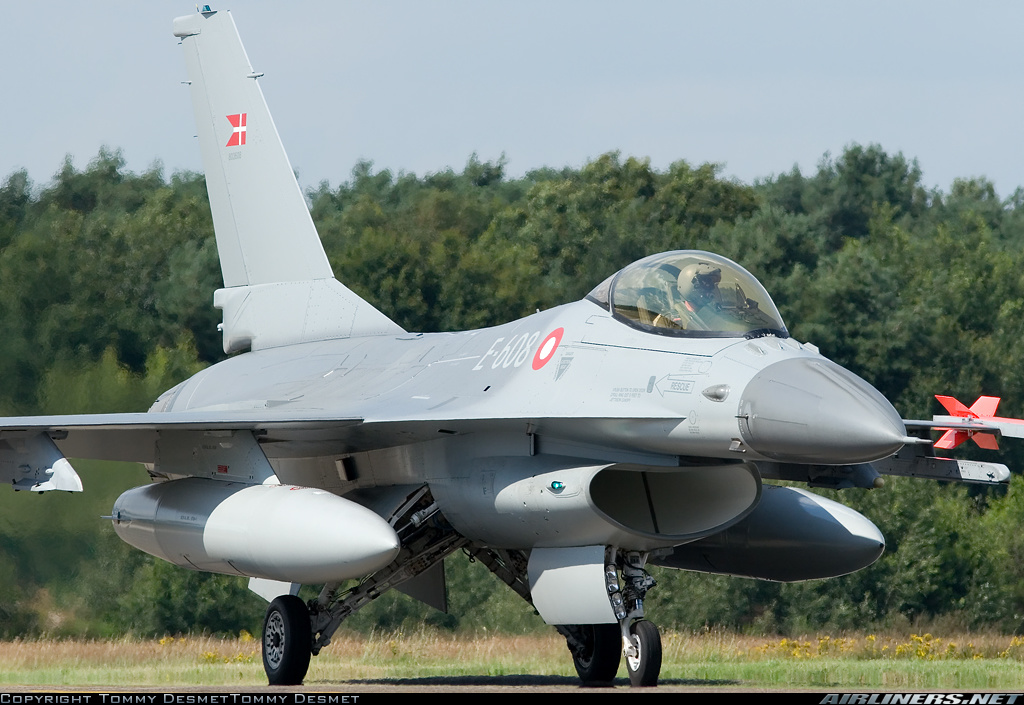

This image most likely belongs to F18 with a 79.92 percent confidence.


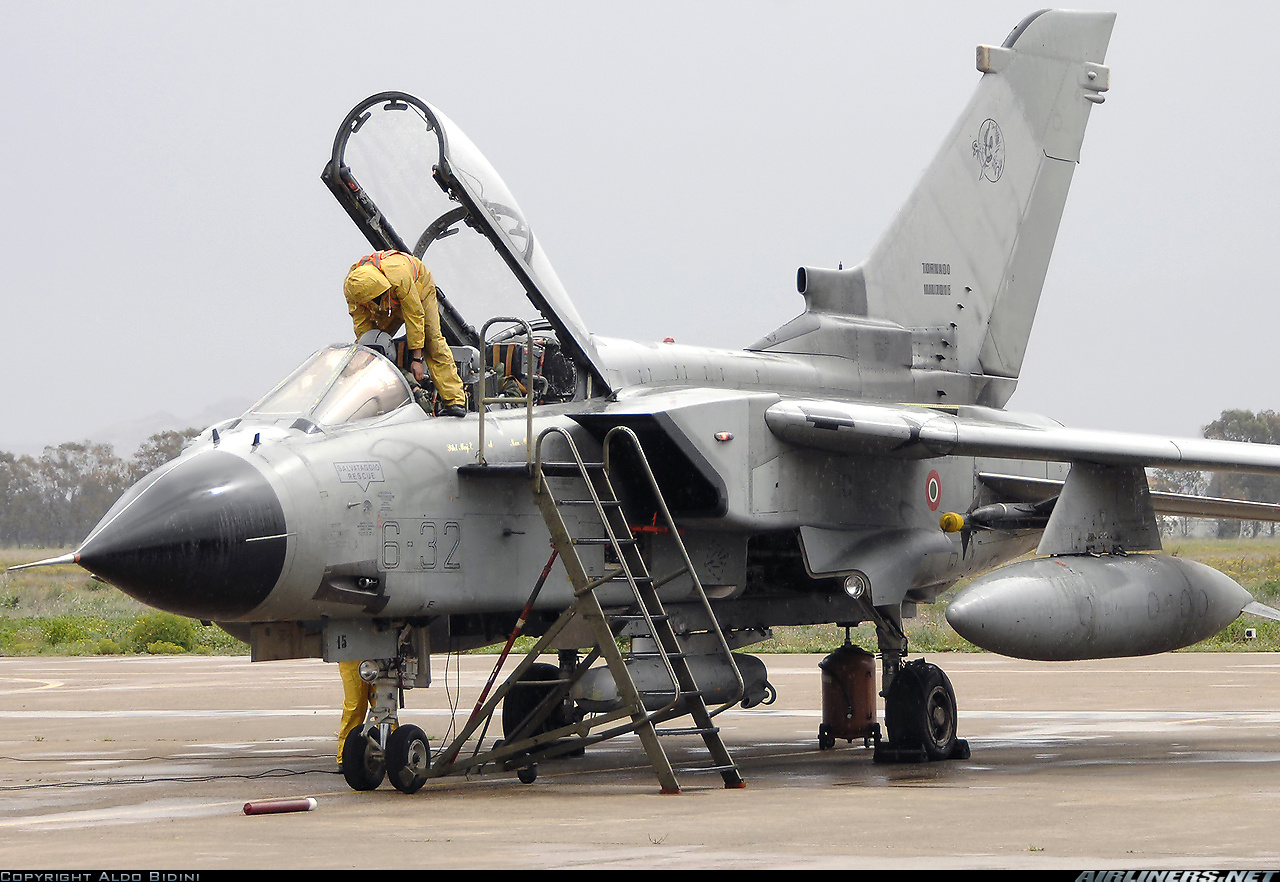

This image most likely belongs to EFA with a 99.97 percent confidence.


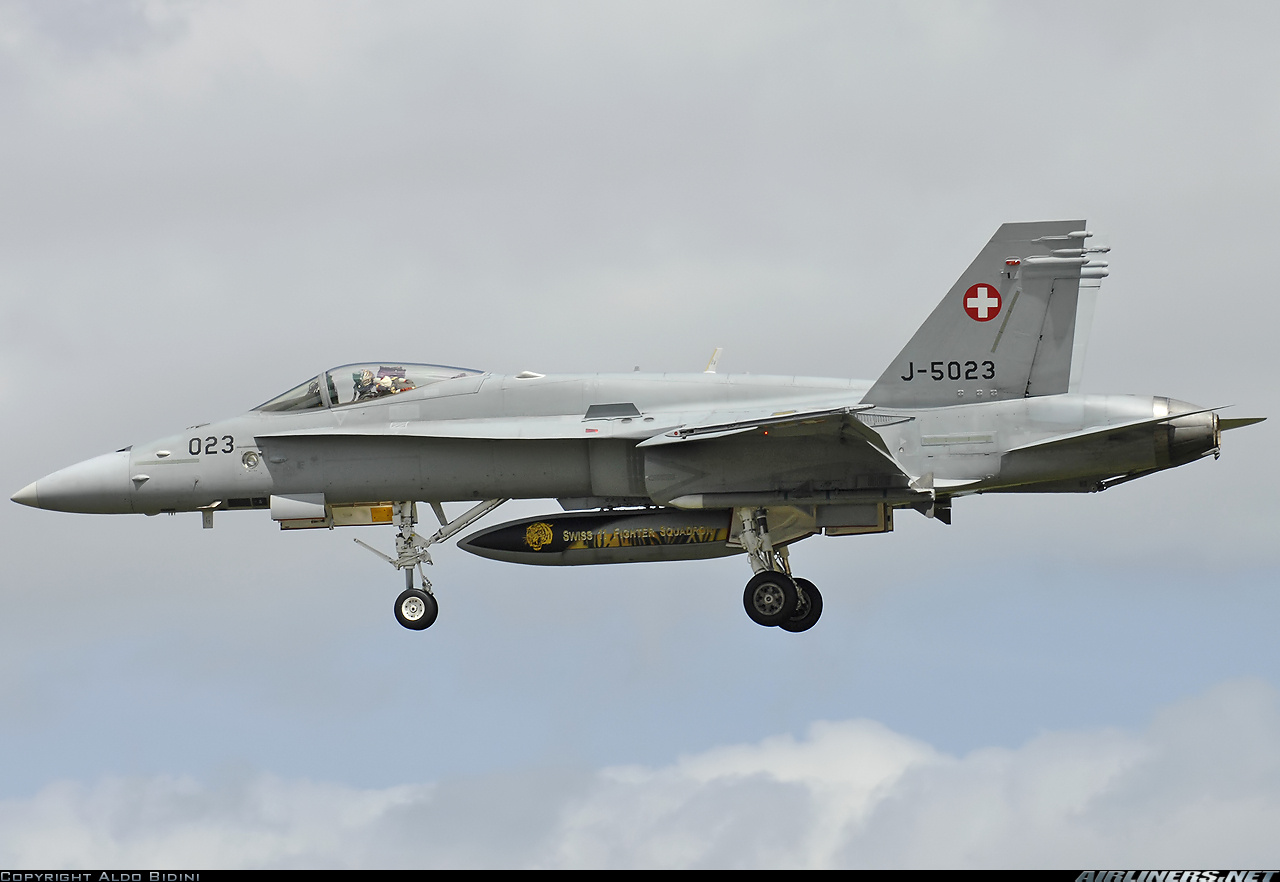

This image most likely belongs to mig29 with a 39.91 percent confidence.


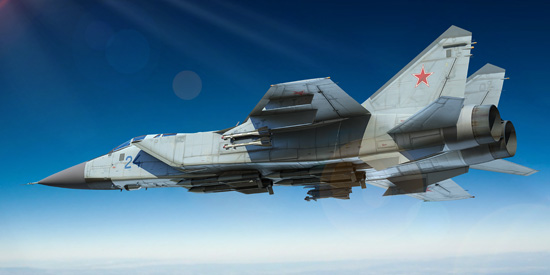

This image most likely belongs to F16 with a 99.98 percent confidence.


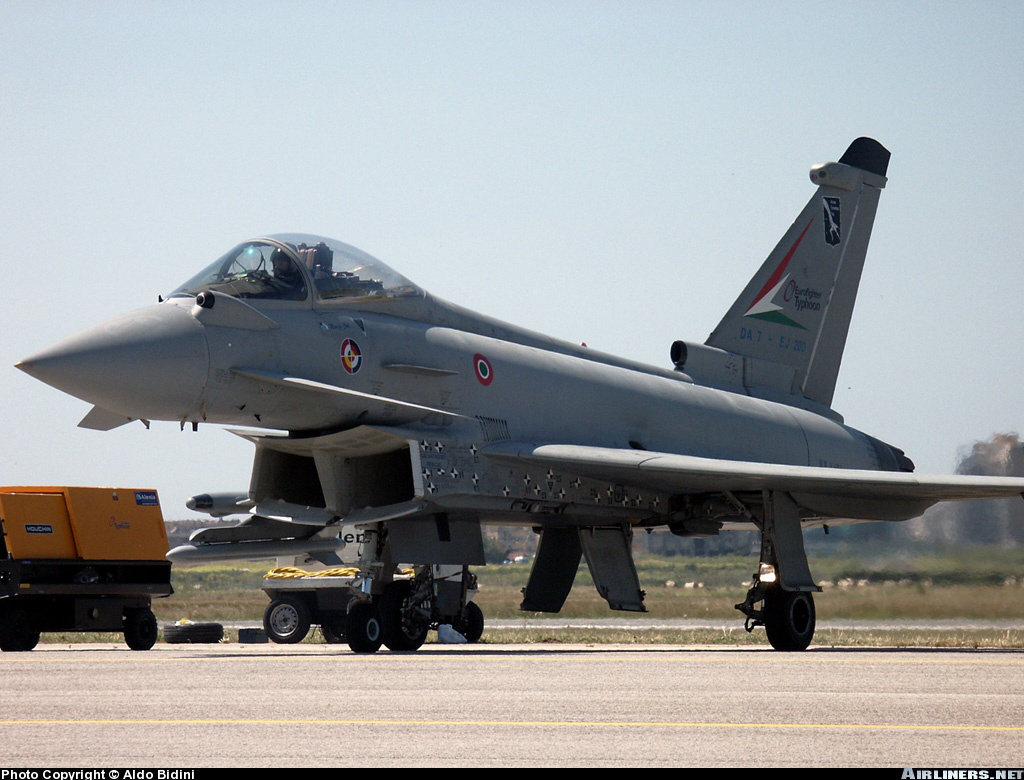

This image most likely belongs to mig29 with a 52.15 percent confidence.


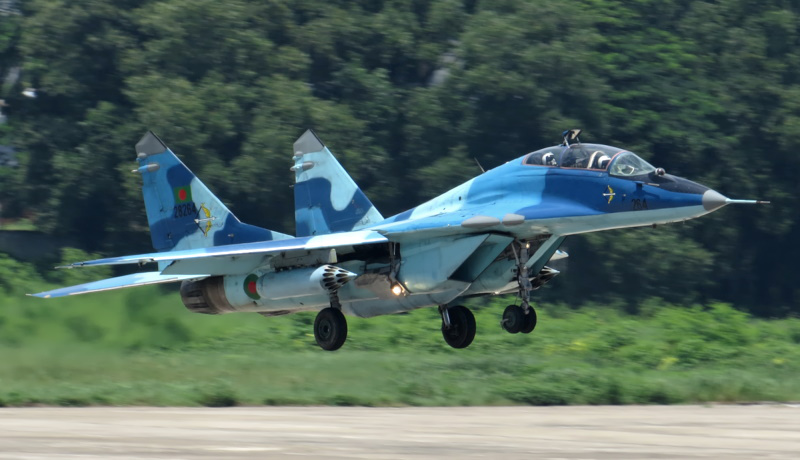

In [ ]:
for dir in os.listdir('test_2/'):
  impath = 'test_2/' + dir + '/' + dir + '.jpg'
  img = tf.keras.utils.load_img(
      impath, target_size=(img_height, img_width))
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])


  print(
      "This image most likely belongs to {} with a {:.2f} percent confidence."
      .format(class_names[np.argmax(score)], 100 * np.max(score))
  )
  oimg = PIL.Image.open(str(impath))
  plt.show(oimg)
  display(oimg)
  plt.close()